## Cегментация клиентов
### RFM анализ

В каждом подсегменте разделим пользователей на 4 класса. 
Рассчитаем количество дней, прошедших с момента последней покупки, с максимальной даты покупки в датасете.

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

# Установим размер графика и цветовую схему
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['image.cmap'] = 'viridis'

In [65]:
#считываем данные
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-o-miadelets/Product_analytics/RFM_ht_data.csv')
df

/opt/tljh/user/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,InvoiceNo,CustomerCode,InvoiceDate,Amount
0,C0011810010001,19067290,2020-09-01,1716.00
1,C0011810010017,13233933,2020-09-01,1489.74
2,C0011810010020,99057968,2020-09-01,151.47
3,C0011810010021,80007276,2020-09-01,146.72
4,C0011810010024,13164076,2020-09-01,104.00
...,...,...,...,...
332725,S0081810310459,14092500,2020-09-30,3801.87
332726,S0081810310461,99065678,2020-09-30,5769.88
332727,S0081810310462,19029918,2020-09-30,736.88
332728,S0081810310463,13020033,2020-09-30,1475.20


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332730 entries, 0 to 332729
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   InvoiceNo     332730 non-null  object 
 1   CustomerCode  332730 non-null  object 
 2   InvoiceDate   332730 non-null  object 
 3   Amount        332730 non-null  float64
dtypes: float64(1), object(3)
memory usage: 10.2+ MB


In [67]:
#корректируем типы данных
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.InvoiceNo = df.InvoiceNo.apply(str)
df.CustomerCode = df.CustomerCode.apply(str)

In [68]:
#смотрим первую и последнюю дату
df['InvoiceDate'].describe()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


count                  332730
unique                     30
top       2020-09-30 00:00:00
freq                    19781
first     2020-09-01 00:00:00
last      2020-09-30 00:00:00
Name: InvoiceDate, dtype: object

In [69]:
#последняя дата
last_date = df['InvoiceDate'].max()
last_date

Timestamp('2020-09-30 00:00:00')

Recency - Количество дней с последнего заказа;

Frequency - Количество заказов;

Monetary Value - Общая сумма по всем заказам.

In [70]:
#создаем таблицу с Recency, Frequency и Monetary Value
rfmTable = df.groupby('CustomerCode').agg({'InvoiceDate': lambda x: (last_date - x.max()).days, # Recency
                                        'InvoiceNo': lambda x: len(x),      # Frequency 
                                        'Amount': lambda x: x.sum()}) # Monetary Value 

rfmTable['InvoiceDate'] = rfmTable['InvoiceDate'].astype(int)
rfmTable.rename(columns={'InvoiceDate': 'recency', 
                         'InvoiceNo': 'frequency', 
                         'Amount': 'monetary_value'}, inplace=True)

In [71]:
rfmTable

,recency,frequency,monetary_value
CustomerCode,,,
02213019,19,1,1609.20
02213042,22,3,9685.48
02213071,29,1,415.00
02213088,23,1,305.00
02213092,25,1,1412.88
...,...,...,...
99099927,10,1,961.10
99099936,0,1,1521.78
99099959,8,2,1444.56


In [72]:
rfmSegmentation = rfmTable


In [73]:
#для разделений на 4 класса используем квантили
quantiles = rfmTable.quantile(q=[0.25, 0.5, 0.75])
quantiles

,recency,frequency,monetary_value
0.25,2.0,1.0,765.00
0.50,8.0,2.0,1834.48
0.75,16.0,3.0,4008.84


In [74]:
#создадим функцию для присвоения класса для Recency, в зависимости от значения (чем ниже значение - тем ниже класс)
def RClass(value,parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 1
    elif value <= quantiles_table[parameter_name][0.50]:
        return 2
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 3
    else:
        return 4

#создадим функцию для присвоения класса для Frequency и Monetary Value, в зависимости от значения 
#(здесь наоборот, чем выше значение - тем ниже класс)
def FMClass(value, parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 4
    elif value <= quantiles_table[parameter_name][0.50]:
        return 3
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 2
    else:
        return 1

In [75]:
#присвоим классы
rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency',quantiles))

rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency',quantiles))

rfmSegmentation['M_Quartile'] = rfmSegmentation['monetary_value'].apply(FMClass, args=('monetary_value',quantiles))

rfmSegmentation['RFMClass'] = rfmSegmentation.R_Quartile.map(str) + rfmSegmentation.F_Quartile.map(str) + rfmSegmentation.M_Quartile.map(str)

In [76]:
rfmSegmentation

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
CustomerCode,,,,,,,
02213019,19,1,1609.20,4,4,3,443
02213042,22,3,9685.48,4,2,1,421
02213071,29,1,415.00,4,4,4,444
02213088,23,1,305.00,4,4,4,444
02213092,25,1,1412.88,4,4,3,443
...,...,...,...,...,...,...,...
99099927,10,1,961.10,3,4,3,343
99099936,0,1,1521.78,1,4,3,143
99099959,8,2,1444.56,2,3,3,233


In [77]:
# максимальное кол-во покупок совершеное одним пользователем
rfmSegmentation.frequency.max()

204

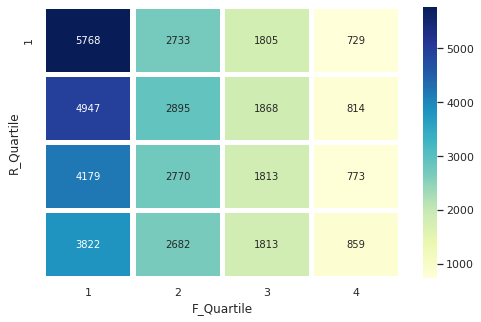

In [78]:
#визуализируем распределение по R и F (в ячейках медианное значение LTV в сегменте)
rfm_table = rfmSegmentation.pivot_table(
                        index='R_Quartile', 
                        columns='F_Quartile', 
                        values='monetary_value', 
                        aggfunc=np.median).applymap(int)
sns.heatmap(rfm_table, cmap="YlGnBu", annot=True, fmt=".0f", linewidths=4.15, annot_kws={"size": 10},yticklabels=4)

In [79]:
# верхняя граница у суммы покупок у пользователей с классом 4 в подсегменте М?
765

765

In [80]:
# нижняя граница у количества покупок у пользователей с классом 1 в подсегменте F?
4

4

In [81]:
# Какое максимальное количество дней может пройти с момента последней покупки для того, чтобы пользователь 
# попал в класс 2 в подсегменте R?
8

8

In [82]:
# Сколько пользователей попало в сегмент 111?
rfmSegmentation.query("RFMClass == '111'").RFMClass.count()

9705

In [83]:
# Сколько пользователей попало в сегмент 311?
rfmSegmentation.query("RFMClass == '311'").RFMClass.count()

1609

In [84]:
# В каком RFM-сегменте самое большое кол-во пользователей?
rfmSegmentation.reset_index().groupby('RFMClass', as_index = False).agg({'CustomerCode': 'count'})\
.rename(columns={'CustomerCode': 'customers'}).sort_values('customers', ascending = False)

#в сегменте (RFMClass) 444 самое большое кол-во пользователей, равное 10624

,RFMClass,customers
63,444,10624
0,111,9705
62,443,6729
47,344,6593
16,211,5847
...,...,...
55,424,63
19,214,60
3,114,60
35,314,33


In [85]:
# Какое количество пользователей попало в самый малочисленный сегмент?
# самый маленький сегмент (RFMClass) 414 содержит 2 пользователя